In [1]:
from zumi.zumi import Zumi
from zumi.util.screen import Screen
import time
from datetime import datetime
from zumi.util.vision import Vision
from zumi.util.camera import Camera 
from zumi.personality import Personality
import pandas as pd
import cv2

zumi =    Zumi()
camera    = Camera()
screen    = Screen()
vision    = Vision()
personality = Personality(zumi, screen)

Starting Zumi 
Pi Zero I2C is available
Verified Pi Zero is the same
Gyroscope previously calibrated
Zumi board detected
Compass detected
OLED Screen detected
Gyroscope & Accelerometer detected
Zumi battery level  49 %


In [2]:
zumi.get_battery_percent()

49

In [3]:
zumi.mpu.calibrate_MPU()

Creating new offset file...
.
.


In [4]:
log = {}
def line_correction(bottom_left, bottom_right, desired_angle, threshold):
    if bottom_left > threshold and bottom_right < threshold:
        desired_angle +=5
    elif bottom_left < threshold and bottom_right > threshold:
        desired_angle -=5
    return desired_angle

def turning_correction(desired_angle, turn_angle):
    if desired_angle >= -turn_angle if desired_angle<0 else turn_angle:
        desired_angle = -abs(turn_angle-abs(desired_angle))
    else:
        desired_angle = abs(turn_angle-abs(desired_angle))
    return desired_angle

def turn_to_check(turn, angle = 90):
    zumi.reset_gyro()
    if turn == 'left':
        zumi.signal_left_on()
        zumi.turn_left(angle)
        zumi.signal_left_off()
    elif turn == 'right':
        zumi.signal_right_on()
        zumi.turn_right(2*angle)
        zumi.signal_right_off()
    time.sleep(0.01)
    desired_angle = zumi.read_z_angle()
    return desired_angle

def move_after_turning(speed, desired_angle):
    zumi.reset_gyro() 
    for x in range(3):
        zumi.go_straight(speed, desired_angle)

def object_detected(threshold=100):
    front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data() # Get center IR sensor value
    
    return front_right < threshold and front_left < threshold

def log_event(action):
    timestamp = datetime.now()
    log[action] = log.setdefault(action, [])
    log[action].append(timestamp)

def circle(turn, number_of_objects, threshold, speed=4):
    log_event("start "+ turn+ " circle")
    zumi.reset_gyro()
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, 0)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break
    for j in range(number_of_objects):
        for i in range(4):
            zumi.reset_gyro()
            if turn == 'left':
                zumi.signal_left_on()
                zumi.turn_left(90)
                zumi.signal_left_off()
                log_event('move_left')
            elif turn == 'right':
                zumi.signal_right_on()
                zumi.turn_right(90)
                zumi.signal_right_off()
                log_event('move_right')
            desired_angle = zumi.read_z_angle()
            desired_angle = turning_correction(desired_angle, 90)
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.reset_gyro()
            while bottom_left > threshold or bottom_right > threshold:
                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
                desired_angle = line_correction(bottom_left, bottom_right, desired_angle, threshold)
                zumi.go_straight(speed, desired_angle)
            zumi.stop()
    log_event("done "+ turn+ " circle")

def dance_360(turn, times):
    if turn == 'left':
        for _ in range(times):
            zumi.reset_gyro()
            zumi.signal_left_on()
            angle_to_turn = 360
            while angle_to_turn > 10:
                zumi.turn_left(angle_to_turn)
                angle_to_turn = 360 - zumi.read_z_angle()
            zumi.signal_left_off()
            zumi.stop()
        return angle_to_turn
    elif turn == 'right':
        for _ in range(times):
            zumi.reset_gyro()
            zumi.signal_right_on()
            angle_to_turn = 360
            while angle_to_turn > 10:
                zumi.turn_right(angle_to_turn)
                angle_to_turn = 360 + zumi.read_z_angle()
            zumi.signal_right_off()
            zumi.stop()
        return angle_to_turn

def find_the_finish_line():
    speed = 20
    threshold = 100
    zumi.reset_gyro()

    turned_left_angle = turn_to_check('left', 80)
    front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
    
    while (bottom_left > threshold and bottom_right > threshold):
        zumi.turn_right(5)
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()


    if (bottom_left < threshold and bottom_right < threshold):
        print("no line left")
        turned_right_angle = turn_to_check('right', 80)        
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        
        while (bottom_left > threshold and bottom_right > threshold):
            zumi.turn_left(5)
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
    zumi.reset_gyro()
    
def find_line(angle_to_turn):
    zumi.reset_gyro()
    speed = 20
    threshold = 100
    # Move if sitll on line
    
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break
    # Move to find new line
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right > threshold and bottom_left > threshold:
            zumi.stop()
            break
    log_event("again_on_line")
    while True:
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        zumi.go_straight(speed, angle_to_turn)
        if bottom_right < threshold and bottom_left < threshold:
            zumi.stop()
            break
    log_event("out_of_line")
    if (log['out_of_line'][-1] - log['again_on_line'][-1]).total_seconds() < 0.3:
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, angle_to_turn)
            if bottom_right > threshold and bottom_left > threshold:
                zumi.stop()
                break
        while True:
            front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            zumi.go_straight(speed, angle_to_turn)
            if bottom_right < threshold and bottom_left < threshold:
                zumi.stop()
                break
        find_the_finish_line()
    elif (log['out_of_line'][-1] - log['again_on_line'][-1]).total_seconds() < 0.6:
        find_the_finish_line()

def what_after_object(speed, number_of_objects, number_of_faces, threshold):
    number_of_turns = number_of_objects - number_of_faces
    camera.start_camera()
    for _ in range(5):
        frame = camera.capture()
        camera.show_image(frame)
        qr_code = vision.find_QR_code(frame)
        message = vision.get_QR_message(qr_code)
        if message != None:
            camera.close()
            screen.draw_text_center("QR Code Detected!")
            log_event("qr_code_command:"+ str(message))
            print("QR code detected!")
            qr_code_command(message, speed, number_of_turns , threshold)
            log_event("qr_code_command:"+ str(message) +"done")
            break
        gray_picture = vision.convert_to_gray(frame)
        faces= vision.find_face(gray_picture)
        if faces != None:
            camera.close()
            screen.draw_text_center("Face Detected!")
            log_event("face_detected")
            print("Face detected!")
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = str(timestamp)+".png"
            cv2.imwrite(filename, gray_picture)
            number_of_faces =+ 1
            break
        time.sleep(1)
    camera.close()
    return number_of_faces

def qr_code_command(message, speed, number_of_turns, threshold):
    print("QR code message: ", message)
    if message == "Left Circle":
        circle('left', number_of_turns, threshold)
    elif message == "Right Circle":
        circle('right', number_of_turns, threshold)
    elif message == "Turn Left":
        zumi.signal_left_on()
        zumi.turn_left(90)
        zumi.signal_left_off()
    elif message == "Turn Right":
        zumi.signal_right_on()
        zumi.turn_right(90)
        zumi.signal_right_off()
    elif message == "Stop":
        zumi.stop()
    elif message == "Zumi is happy today!":
        personality.happy()
    elif message == "Zumi is angry today!":
        personality.angry()
    elif message == "Zumi is celebrating today!":
        personality.celebrate()
    elif "360" in str(message):

        spin_message = message.split(" ")
        times = int(spin_message[0])
        turn = spin_message[3][:-1]
        emotion = spin_message[-1]

        print("turn", turn)
        angle_to_turn = dance_360(turn, times)*2

        if emotion == "happy":
            personality.happy()
        elif emotion == "angry":
            personality.angry()
        elif emotion == "celebrate":
            personality.celebrate()
        zumi.stop()
        
        print("Angle to turn: ", angle_to_turn)
        find_line(angle_to_turn)
    else:
        print("Invalid command")
        return "Invalid command"

def move_after_turning(speed, desired_angle):
    zumi.reset_gyro() 
    for x in range(3):
        zumi.go_straight(speed, desired_angle)

def finish_with_180_turn():
    zumi.stop()
    log_event("finish")
    print("Reached end. Performing 180° turn.")
    screen.draw_text_center("Finisher box\nTurning 180°")
    zumi.turn_left(180)
    screen.draw_text_center("Done!")

def save_dict_to_csv(data_dict):
    # Generate file name with current time
    current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_name = "Zumi7337_output_" + current_time + ".csv"

    # Create empty list to store rows
    rows = []

    # Go through all actions and timestamps
    for action, timestamps in data_dict.items():
        for timestamp in timestamps:
            # Add row to list of rows
            rows.append({"timestamp": timestamp, "action": action})

    # Create DataFrame from list of rows
    df = pd.DataFrame(rows)

    # Sort DataFrame by column timestamp
    df = df.sort_values(by='timestamp')

    # Save DataFrame in CSV file
    df.to_csv(file_name, index=False)
    print("Data saved in ", file_name)

speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
speed 10 desired angle -0.002
Waiting for object to be removed...
Object removed. Resuming movement.
Starting PiCamera


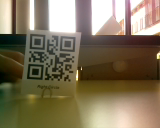

Closing PiCamera
QR code detected!
QR code message:  Right Circle
Closing PiCamera
speed 10 desired angle -0.002
speed 10 desired angle -1.1440000000000055
speed 10 desired angle -1.1440000000000055
speed 10 desired angle -1.1440000000000055
speed 10 desired angle -1.1440000000000055
speed 10 desired angle -1.1440000000000055
speed 10 desired angle -1.1440000000000055
speed 10 desired angle -1.1440000000000055
speed 10 desired angle -1.1440000000000055
speed 10 desired angle 3.8559999999999945
speed 10 desired angle 8.855999999999995
speed 10 desired angle 8.855999999999995
speed 10 desired angle 8.855999999999995
speed 10 desired angle 8.855999999999995
speed 10 desired angle 8.855999999999995
speed 10 desired angle 8.855999999999995
speed 10 desired angle 8.855999999999995
speed 10 desired angle 8.855999999999995
speed 10 desired angle 0.24100000000001387
speed 10 desired angle 0.24100000000001387
speed 10 desired angle 0.24100000000001387
speed 10 desired angle -4.758999999999986
sp

KeyboardInterrupt: 

In [ ]:
log = {}
zumi.reset_gyro()
desired_angle = zumi.read_z_angle() 
number_of_objects = 0
number_of_faces = 0

log_event('start')
log_event('end_line')

try:
    while True:
        # Set the threshold for the IR sensors and the speed
        threshold = 50 
        speed = 10

        if object_detected():
            zumi.stop()

            zumi.play_note(1, 500) # 1 is note type (1 - 60), 500 is duration in ms
            log_event('object_detected')
            screen.draw_text_center("Object detected") #Message that object was detected
            print("Waiting for object to be removed...")
            
            zumi.brake_lights_on()
            while object_detected():
                zumi.stop()
                time.sleep(0.1)
            zumi.brake_lights_off()
            
            number_of_objects += 1

            log_event('object_removed')
            print("Object removed. Resuming movement.")
            log_event('loking for qr_code of face')
            
            number_of_faces = what_after_object(speed, number_of_objects, number_of_faces, threshold)
        if "done right circle" in log:
            if (log['done right circle'][-1]- datetime.now()).total_seconds() < 3:
                time.sleep(3)
                log['finish right circle'] = log.pop('done right circle')
        elif "done left circle" in log:
            if(log['done left circle'][-1]- datetime.now()).total_seconds() < 3:
                time.sleep(3) 
                log['finish left circle'] = log.pop('done left circle')
    
        # Read all IR sensor values
        front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
        
        # Correction to line if one sensor is on the line and the other is off
        desired_angle = line_correction(bottom_left, bottom_right, desired_angle, threshold)
        time.sleep(0.01) 
        # Move forward with the corrected heading
        if bottom_left > threshold or bottom_right > threshold:
            zumi.go_straight(speed, desired_angle)
        else:
            log_event('end_line')
            if "done right circle" in log:
                if (log['done right circle'][-1]- datetime.now()).total_seconds() < 3:
                    time.sleep(3)
                    log['finish right circle'] = log.pop('done right circle')
            elif "done left circle" in log:
                if(log['done left circle'][-1]- datetime.now()).total_seconds() < 3:
                    time.sleep(3) 
                    log['finish left circle'] = log.pop('done left circle')
            if (log['end_line'][-1] - log['end_line'][-2]).total_seconds() > 3:
                go_left = True
            
                log_event('check_left')
                # Turn to check if left is line
                turned_left_angle = turn_to_check('left')

                # Calculate angle if turn was too much or not enough
                desired_angle = turning_correction(turned_left_angle, 90)

                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()
            else:
                go_left = False
            if (bottom_left > threshold or bottom_right > threshold) and go_left:
                log_event('move_left')
                move_after_turning(speed, desired_angle)
            else:
                
                log_event('check_right')
                # Turn to check if right is line
                turned_right_angle = turn_to_check('right') 
                
                # Calculate angle if turn was too much or not enough
                desired_angle = turning_correction(turned_right_angle, 180)

                front_right, bottom_right, back_right, bottom_left, back_left, front_left = zumi.get_all_IR_data()

                if bottom_left > threshold or bottom_right > threshold:
                    log_event('move_right')
                    move_after_turning(speed, desired_angle)
                else:
                    zumi.stop()
                    log_event('stop')
                    finish_with_180_turn()
                    log_event('finish_with_180_turn')
                    break
finally:
    zumi.stop()
    log_event('stop')
    #save_dict_to_csv(log)

In [9]:
save_dict_to_csv(log)

Data saved in  Zumi7337_output_20250527_090958.csv
